## Import Packages

In [1]:
%pylab inline
import scipy
import h5py
import skimage
import os
from skimage import io,transform,img_as_float
from skimage.io import imread,imsave
from collections import OrderedDict
import decimal
notebook_dir = os.getcwd()
project_dir = os.path.split(notebook_dir)[0]
result_dir = project_dir + '/Results/Images/'
if not os.path.isdir(result_dir):
    os.makedirs(result_dir)
tmp_dir = project_dir + '/Tmp/'
if not os.path.isdir(tmp_dir):
    os.makedirs(tmp_dir)
photo_dir = project_dir + '/Images/ControlPaper/'
art_dir = project_dir + '/Images/ControlPaper/'

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:128: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the matplotlib toolkit finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Populating the interactive namespace from numpy and matplotlib


## Define auxiliary functions

In [2]:
#functions to save and load hdf5 files to pass data to torch
def make_torch_input(filename, layers, loss_functions, args):
    f = h5py.File(filename,'w')
    for l,layer in enumerate(layers):
        layer_group = f.create_group(layer)
        for lf,loss_function in enumerate(loss_functions[l]):
            lf_group = layer_group.create_group(loss_function)
            for arg in args[l][lf]:
                dataset = lf_group.create_dataset(arg, data=args[l][lf][arg])
    f.close()
    
def make_torch_init(filename, init):
    f = h5py.File(filename,'w')
    f.create_dataset('init', data=init)
    f.close()

def get_torch_output(filename):
    f = h5py.File(filename,'r')
    data = f['opt_result']
    return data.value
    f.close()
    
def get_torch_loss(filename):
    f = h5py.File(filename,'r')
    data = f['losses']
    return data.value
    f.close()

def list2css(layers):
    '''
    Takes list of strings and returns comma separated string
    '''
    css = str()
    for l in layers:
        css = css+l+','
    return css[:-1]

def get_activations(images, caffe_model, layers='all', gpu=0):
    '''
    Function to get neural network activations in response to images from torch.
    
    :param images: array of images
    :param caffe_model: file name of the network .caffemodel file
    :param layers: network layers for which the activations should be computed
    :return: network activations in response to images
    '''
    layers = list2css(layers)
    images_file_name = tmp_dir + 'images.hdf5'
    output_file_name = tmp_dir + 'activations.hdf5'
    f = h5py.File(images_file_name, 'w')
    f.create_dataset('images', data=images)
    f.close()
    context = {
    'caffe_model': caffe_model,
    'images': images_file_name,
    'layers': layers,
    'gpu': gpu,
    'backend': 'cudnn',
    'output_file': output_file_name,
    'project_dir': project_dir
    }
    template = ('#!/bin/bash\n' +
                'cd {project_dir} && ' + 
                '/usr/local/torch/install/bin/th ComputeActivations.lua ' + 
                '-caffe_model {caffe_model} ' +
                '-images {images} ' + 
                '-layers {layers} ' + 
                '-gpu {gpu} ' + 
                '-backend {backend} ' +
                '-output_file {output_file}')
    script_name = project_dir + '/get_activations.sh'
    with open(script_name, 'w') as script:
        script.write(template.format(**context))
    os.chmod(script_name, 0o755)
    #execute script 
    !{script_name} >/dev/null
    f = h5py.File(output_file_name,'r')
    act = OrderedDict()
    for key in f.keys():
        act[key] = f[key].value.copy()
    f.close()
    return act

def preprocess(image):
    assert(image.max() <= 1.001)
    imagenet_mean = array([0.40760392,  0.45795686,  0.48501961])
    image_torch = 255 * (image[:,:,::-1] - imagenet_mean).transpose(2,0,1)
    return image_torch

def deprocess(image_torch):
    imagenet_mean = array([0.40760392,  0.45795686,  0.48501961])
    image = (image_torch.transpose(1,2,0)/255. + imagenet_mean)[:,:,::-1]
    image[image>1] = 1
    image[image<0] = 0
    return image

def gram_matrix(activations):
    n_fm = activations.shape[0]
    F = activations.reshape(n_fm,-1)
    G = F.dot(F.T) / F[0,:].size
    return G

import itertools
def flatten(l):
    return list(itertools.chain.from_iterable(l))

def set_model(name, project_dir):
    if name == 'org_pad':
        model = project_dir + '/Models/VGG_ILSVRC_19_layers_conv.caffemodel'
    elif name == 'norm_pad':
        model = project_dir + '/Models/vgg_normalised.caffemodel'
    else:
        assert False, 'unknown model name'
    return model

## Set parameters

### Standard parameters for the original vgg-19 net - often better for portraits

In [3]:
#define image names and paths
img_dirs = OrderedDict()
img_dirs['content'] = photo_dir
img_dirs['style'] = art_dir
img_names = OrderedDict()
img_names['content'] = 'suppfig4_content2.jpg'
img_names['style'] = 'suppfig7_style1.jpg'
#define loss layers for each image
layers = OrderedDict()
layers['content'] =  ['relu4_2']
layers['style'] = ['relu1_1','relu2_1','relu3_1','relu4_1','relu5_1']
layers_now = layers['style'] + layers['content']
#define initialisation for gradient descent image|random for content image or white noise
init = 'image'
#define loss network to be used org_pad|norm_pad for original or normalised vgg19 network
model_name = 'org_pad'
caffe_model = set_model(model_name, project_dir)
#define file names for temporary files that are passed to torch
input_file_name = tmp_dir + 'input.hdf5'
init_file_name = tmp_dir + 'init.hdf5'
output_file_name = tmp_dir + 'output.hdf'
#define loss functions to be used, list of lists. For one list for each layer in layers_now 
loss_functions = [['GramMSE']] * len(layers['style']) + [['MSE']]
#define weights for the loss functions
sw = 1e3
cw = 1
weights = OrderedDict()
weights['style'] = [
    [array([sw/64**2])],
    [array([sw/128**2])],
    [array([sw/256**2])],
    [array([sw/512**2])],
    [array([sw/512**2])],
]
weights['content'] = [[array([cw])]]
#define other parameters set hr_img_size=None to skip high-resolution step
img_size = 512
max_iter = 500
hr_img_size = 1024
hr_max_iter = 200
gpu = 0
#define the name of the stylised image.
lf = list2css(map(str,loss_functions));lf = str.replace(lf,'[','');lf = str.replace(lf,']','')
result_image_name = (
'cimg_' + img_names['content'] + 
'_simg_' + img_names['style'] + 
'_sz_' + str(img_size) + 
'_model_' + model_name + 
'_layers_' + list2css(layers_now) + 
'_lf_' + lf +
'_sw_' + '%.1E'%decimal.Decimal(sw) + 
'_cw_' + '%.1E'%decimal.Decimal(cw) + 
'_init_' + init +
'.jpg'
)

### Standard parameters for the normalised vgg-19 net - can be better for landscapes

In [4]:
# img_dirs = OrderedDict()
# img_dirs['content'] = photo_dir
# img_dirs['style'] = art_dir
# img_names = OrderedDict()
# img_names['content'] = 'suppfig4_content2.jpg'
# img_names['style'] = 'suppfig7_style1.jpg'
# layers = OrderedDict()
# layers['content'] =  ['relu4_2']
# layers['style'] = ['relu1_1','relu2_1','relu3_1','relu4_1','relu5_1']
# layers_now = layers['style'] + layers['content']
# img_size = 512
# max_iter = 500
# hr_img_size = 1024
# hr_max_iter = 200
# gpu = 0
# init = 'image'
# model_name = 'norm_pad'
# caffe_model = set_model(model_name, project_dir)
# input_file_name = tmp_dir + 'input.hdf5'
# init_file_name = tmp_dir + 'init.hdf5'
# output_file_name = tmp_dir + 'output.hdf'
# sw = 1e9 / len(layers['style'])
# cw = 1e6
# weights = OrderedDict()
# weights['style'] = [[array([sw])]] * len(layers['style'])
# weights['content'] = [[array([cw])]]
# loss_functions = [['GramMSE']] * len(layers['style']) + [['MSE']]
# lf = list2css(map(str,loss_functions));lf = str.replace(lf,'[','');lf = str.replace(lf,']','')
# result_image_name = (
# 'cimg_' + img_names['content'] + 
# '_simg_' + img_names['style'] + 
# '_sz_' + str(img_size) + 
# '_model_' + model_name + 
# '_layers_' + list2css(layers_now) + 
# '_lf_' + lf +
# '_sw_' + '%.1E'%decimal.Decimal(sw) + 
# '_cw_' + '%.1E'%decimal.Decimal(cw) + 
# '_init_' + init +
# '.jpg'
# )

### Run stylisation and save results

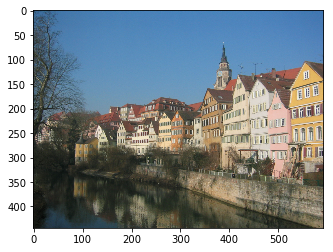

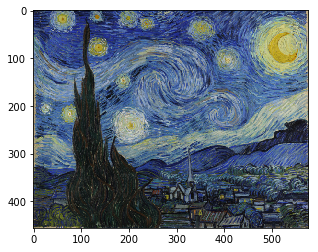

Successfully loaded /gpfs01/bethge/home/lgatys/NeuralImageSynthesis/Models/VGG_ILSVRC_19_layers_conv.caffemodel
conv1_1: 64 3 3 3
conv1_2: 64 64 3 3
conv2_1: 128 64 3 3
conv2_2: 128 128 3 3
conv3_1: 256 128 3 3
conv3_2: 256 256 3 3
conv3_3: 256 256 3 3
conv3_4: 256 256 3 3
conv4_1: 512 256 3 3
conv4_2: 512 512 3 3
conv4_3: 512 512 3 3
conv4_4: 512 512 3 3
conv5_1: 512 512 3 3
conv5_2: 512 512 3 3
conv5_3: 512 512 3 3
conv5_4: 512 512 3 3
Running optimization with L-BFGS	
<optim.lbfgs> 	creating recyclable direction/step/history buffers	
Iteration 50 / 500	
relu1_1	
GramMSE loss: 42312.919617	
relu2_1	
GramMSE loss: 281870.788574	
relu3_1	
GramMSE loss: 81805.084229	
relu4_1	
GramMSE loss: 477769.195557	
relu5_1	
GramMSE loss: 6846.429825	
relu4_2	
MSE loss: 370374.937500	
Total loss: 1260979.355301	
Iteration 100 / 500	
relu1_1	
GramMSE loss: 25844.772339	
relu2_1	
GramMSE loss: 70588.661194	
relu3_1	
GramMSE loss: 26393.470764	
relu4_1	
GramMSE loss: 166011.840820	
relu5_1	
GramMSE lo

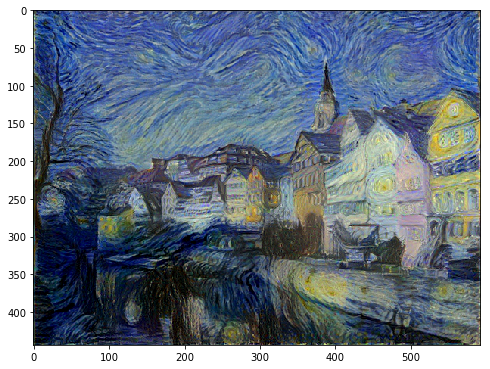

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


no downsampling: suppfig4_content2.jpg


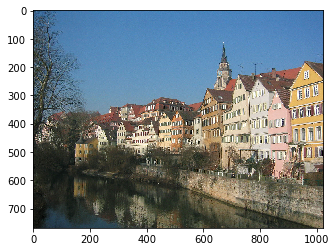

no downsampling: suppfig7_style1.jpg


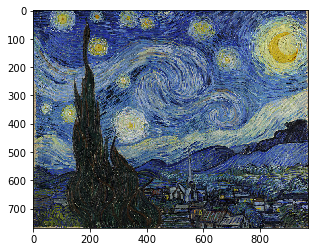

Successfully loaded /gpfs01/bethge/home/lgatys/NeuralImageSynthesis/Models/VGG_ILSVRC_19_layers_conv.caffemodel
conv1_1: 64 3 3 3
conv1_2: 64 64 3 3
conv2_1: 128 64 3 3
conv2_2: 128 128 3 3
conv3_1: 256 128 3 3
conv3_2: 256 256 3 3
conv3_3: 256 256 3 3
conv3_4: 256 256 3 3
conv4_1: 512 256 3 3
conv4_2: 512 512 3 3
conv4_3: 512 512 3 3
conv4_4: 512 512 3 3
conv5_1: 512 512 3 3
conv5_2: 512 512 3 3
conv5_3: 512 512 3 3
conv5_4: 512 512 3 3
Running optimization with L-BFGS	
<optim.lbfgs> 	creating recyclable direction/step/history buffers	
Iteration 50 / 200	
relu1_1	
GramMSE loss: 897.820473	
relu2_1	
GramMSE loss: 41997.932434	
relu3_1	
GramMSE loss: 33281.608582	
relu4_1	
GramMSE loss: 112886.848450	
relu5_1	
GramMSE loss: 2112.491131	
relu4_2	
MSE loss: 506174.875000	
Total loss: 697351.576069	
Iteration 100 / 200	
relu1_1	
GramMSE loss: 694.533050	
relu2_1	
GramMSE loss: 9814.655304	
relu3_1	
GramMSE loss: 9105.012894	
relu4_1	
GramMSE loss: 50985.759735	
relu5_1	
GramMSE loss: 1992.

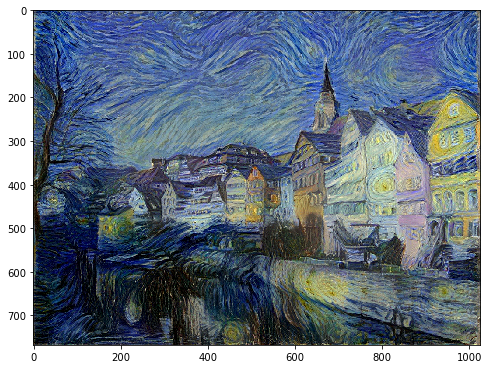

In [5]:
if os.path.isfile(result_dir + result_image_name) == False: #check if file exists
    conditions = img_names.keys()
    imgs = OrderedDict()
    imgs_torch = OrderedDict()
    act = OrderedDict()
    #get images, resample and preprocess them and compute their activations
    for cond in conditions:
        imgs[cond] = img_as_float(imread(img_dirs[cond] + img_names[cond]))
        if imgs[cond].ndim == 2:
            imgs[cond] = tile(imgs[cond][:,:,None],(1,1,3))
        try:
            imgs[cond] = transform.pyramid_reduce(imgs[cond], sqrt(float(imgs[cond][:,:,0].size) / img_size**2))
        except:
            print('no downsampling: ' + img_names[cond]) #if the image is too small, just keep its original size
        imshow(imgs[cond]);show()
        imgs_torch[cond] = preprocess(imgs[cond])
        act[cond] = get_activations(imgs_torch[cond],
                                    caffe_model,
                                    layers=layers[cond],
                                    gpu=gpu
                                   )
    #generate initialisation
    if init == 'image':
        make_torch_init(init_file_name, imgs_torch['content'])
    elif init == 'random':
        make_torch_init(init_file_name, randn(*imgs_torch['content'].shape))
    else: 
        raise NameError('Unknown init')
    #generate the arguments for the loss functions
    args = OrderedDict()
    args['style'] = [
                        [
                            {'targets': gram_matrix(act['style'][layer])[None,:],
                             'weights': weights['style'][l][0]} 
                        ] 
                    for l,layer in enumerate(layers['style'])]
    args['content'] = [[{'targets': act['content'][layers['content'][0]][None,:],'weights': weights['content'][0][0]}],]                
    args_now = args['style'] + args['content']
    make_torch_input(input_file_name, layers_now, loss_functions, args_now)
    #write bash script to execute torch code
    context = {
        'caffe_model': caffe_model,
        'input_file': input_file_name,
        'init_file': init_file_name,
        'gpu': gpu,
        'max_iter': max_iter,
        'backend': 'cudnn',
        'print_iter': 50,
        'save_iter': 0,
        'layer_order': list2css(layers_now),
        'output_file': output_file_name,
        'project_dir': project_dir
    }
    template = (
                '#!/bin/bash\n' +
                'cd {project_dir} && ' + 
                'time /usr/local/torch/install/bin/th ImageSynthesis.lua ' + 
                '-caffe_model {caffe_model} ' +
                '-input_file {input_file} ' + 
                '-init_file {init_file} ' + 
                '-gpu {gpu} ' + 
                '-max_iter {max_iter} ' +
                '-print_iter {print_iter} ' +
                '-save_iter {save_iter} ' +
                '-backend {backend} ' + 
                '-layer_order {layer_order} ' +
                '-output_file {output_file}'
               )
    script_name = project_dir + '/run_synthesis.sh'
    with open(script_name, 'w') as script:
        script.write(template.format(**context))
    os.chmod(script_name, 0o755)
    #execute script
    !{script_name}
    #load stylisation output, display and save as image
    output = deprocess(get_torch_output(output_file_name))
    imshow(output);gcf().set_size_inches(8,14);show()
    imsave(result_dir + result_image_name, output)

#Make result high resolution, to skip this set hr_img_size = None
if hr_img_size: 
    lr_output = img_as_float(imread(result_dir + result_image_name))
    result_image_name = (
    'cimg_' + img_names['content'] + 
    '_simg_' + img_names['style'] + 
    '_sz_' + str(img_size) + 
    '_hrsz_' + str(hr_img_size) + 
    '_model_' + model_name + 
    '_layers_' + list2css(layers_now) + 
    '_lf_' + lf +
    '_sw_' + '%.1E'%decimal.Decimal(sw) + 
    '_cw_' + '%.1E'%decimal.Decimal(cw) + 
    '_init_' + init +
    '.jpg'
    )
    if os.path.isfile(result_dir + result_image_name) == False: #check if file exists
        conditions = img_names.keys()
        imgs = OrderedDict()
        imgs_torch = OrderedDict()
        act = OrderedDict()
        for cond in conditions:
            imgs[cond] = img_as_float(imread(img_dirs[cond] + img_names[cond]))
            if imgs[cond].ndim == 2:
                imgs[cond] = tile(imgs[cond][:,:,None],(1,1,3))
            try:
                imgs[cond] = transform.pyramid_reduce(imgs[cond], sqrt(float(imgs[cond][:,:,0].size) / hr_img_size**2))
            except:
                print('no downsampling: ' + img_names[cond])
            imshow(imgs[cond]);show()
            imgs_torch[cond] = preprocess(imgs[cond])
            act[cond] = get_activations(imgs_torch[cond],
                                        caffe_model,
                                        layers=layers[cond],
                                        gpu=gpu
                                       )
        hr_init = preprocess(img_as_float(scipy.misc.imresize(lr_output, imgs['content'].shape)))
        make_torch_init(init_file_name, hr_init)
        args = OrderedDict()
        args['style'] = [
                            [
                                {'targets': gram_matrix(act['style'][layer])[None,:],
                                 'weights': weights['style'][l][0]} 
                            ] 
                        for l,layer in enumerate(layers['style'])]
        args['content'] = [[{'targets': act['content'][layers['content'][0]][None,:],'weights': weights['content'][0][0]}],]                
        layers_now = layers['style'] + layers['content']
        args_now = args['style'] + args['content']
        make_torch_input(input_file_name, layers_now, loss_functions, args_now)
        context = {
            'caffe_model': caffe_model,
            'input_file': input_file_name,
            'init_file': init_file_name,
            'gpu': gpu,
            'max_iter': hr_max_iter,
            'backend': 'cudnn',
            'print_iter': 50,
            'save_iter': 0,
            'layer_order': list2css(layers_now),
            'output_file': output_file_name,
            'project_dir': project_dir
        }
        template = (
                    '#!/bin/bash\n' +
                    'cd {project_dir} && ' + 
                    'time /usr/local/torch/install/bin/th ImageSynthesis.lua ' + 
                    '-caffe_model {caffe_model} ' +
                    '-input_file {input_file} ' + 
                    '-init_file {init_file} ' + 
                    '-gpu {gpu} ' + 
                    '-max_iter {max_iter} ' +
                    '-print_iter {print_iter} ' +
                    '-save_iter {save_iter} ' +
                    '-backend {backend} ' + 
                    '-layer_order {layer_order} ' +
                    '-output_file {output_file}'
                   )
        script_name = project_dir + '/run_synthesis.sh'
        with open(script_name, 'w') as script:
            script.write(template.format(**context))
        os.chmod(script_name, 0o755)
        #execute script
        !{script_name}
        output = deprocess(get_torch_output(output_file_name))
        imshow(output);gcf().set_size_inches(8,14);show()
        imsave(result_dir + result_image_name, output)